# Segmenting Satellite Images
Maria Nicolae
Mitcan Radu Constantin
Junzhe Yin
Alexander Stromberger


In [ ]:
!tar -xvf sentinel.tar

sentinel/
sentinel/extrait2b_B02.tif
sentinel/extrait3b_B08.tif
sentinel/extrait3b_B03.tif
sentinel/extrait2b_B04.tif
sentinel/extrait2b_B08.tif
sentinel/extrait3b_B02.tif
sentinel/extrait2b_B03.tif
sentinel/extrait3b_B04.tif
sentinel/README


In [ ]:
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage
import numpy as np
import skimage.morphology as morpho
import scipy.ndimage

In [ ]:
img_b2 = skio.imread("sentinel/extrait3b_B02.tif")
img_b3 = skio.imread("sentinel/extrait3b_B03.tif")
img_b4 = skio.imread("sentinel/extrait3b_B04.tif")
img_b8 = skio.imread("sentinel/extrait3b_B08.tif")

img_irg = np.dstack([img_b8,img_b4,img_b3])
img_rgb = np.dstack([img_b4,img_b3,img_b2])

def calc_ndvi(irg):
  ndvi = np.clip((irg[:,:,0]-irg[:,:,1])/(irg[:,:,0]+irg[:,:,1]),0,1)
  return ndvi

ndvi = calc_ndvi(img_irg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Histograms

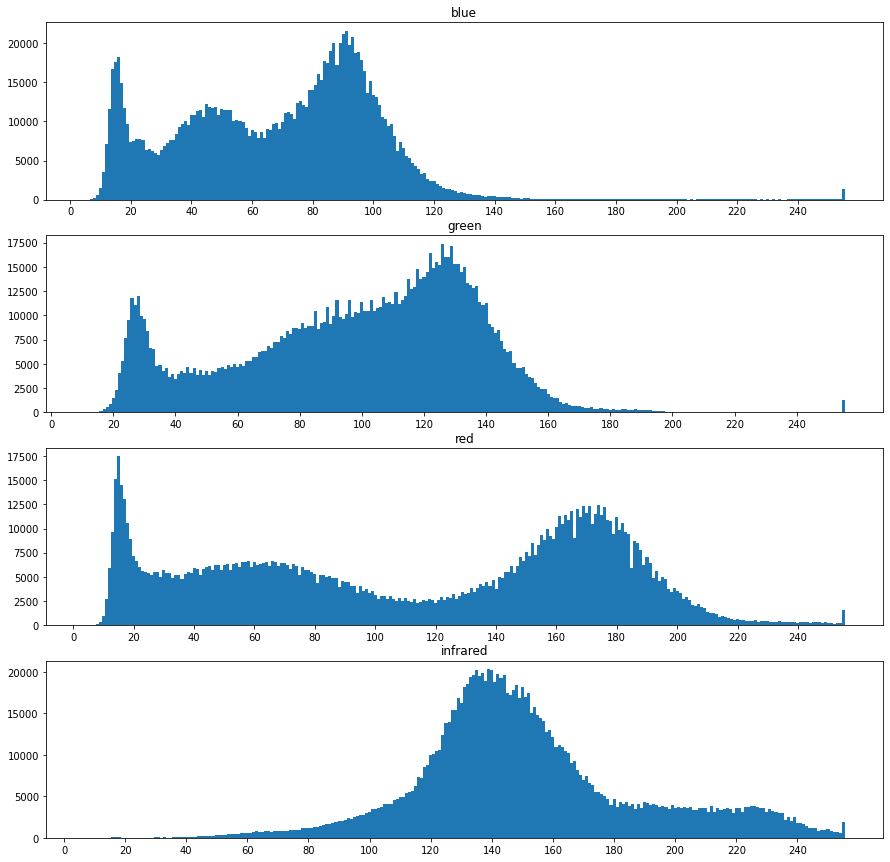

In [ ]:

images = [img_b2, img_b3, img_b4, img_b8  ]
channels = ['blue', 'green', 'red', 'infrared']

fig, ax = plt.subplots(4, 1, figsize = (15, 15))

i = 0 
for img in images:  
  using_img = img
  nbins = 256
  histogram = skimage.exposure.histogram(using_img, nbins)
  ax[i].set_title(channels[i])
  ax[i].set_xticks(np.arange(start = 0, stop = 260, step = 20))
  ax[i].bar(histogram[1],histogram[0], width = 1)
  i+=1

# Segmentation

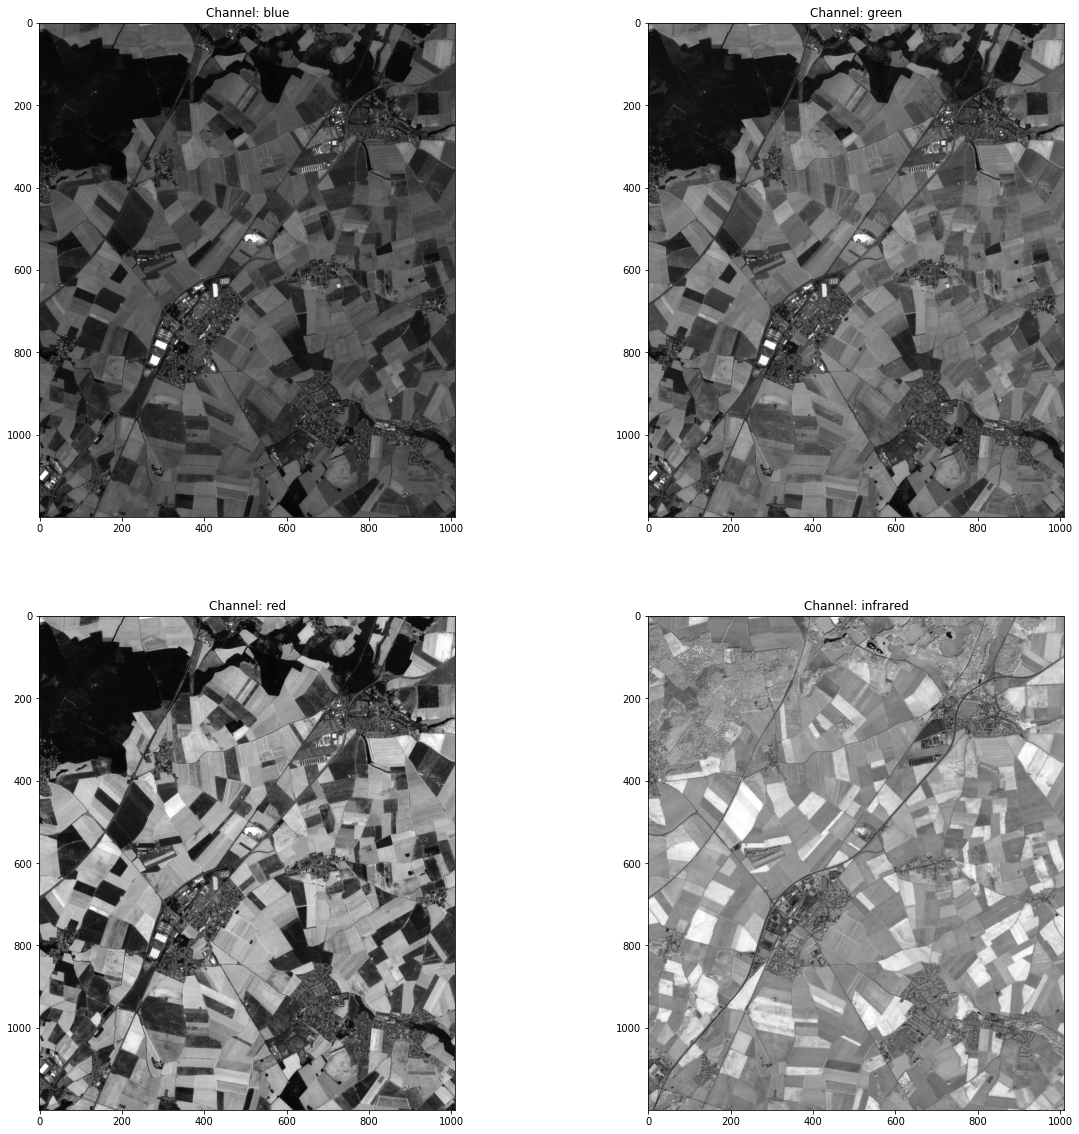

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (20, 20))
i = 0
for img in images:
  ax[i//2,i%2].set_title(f'Channel: {channels[i]}')
  ax[i//2,i%2].imshow(img, cmap = 'gray')
  i+=1
plt.show()

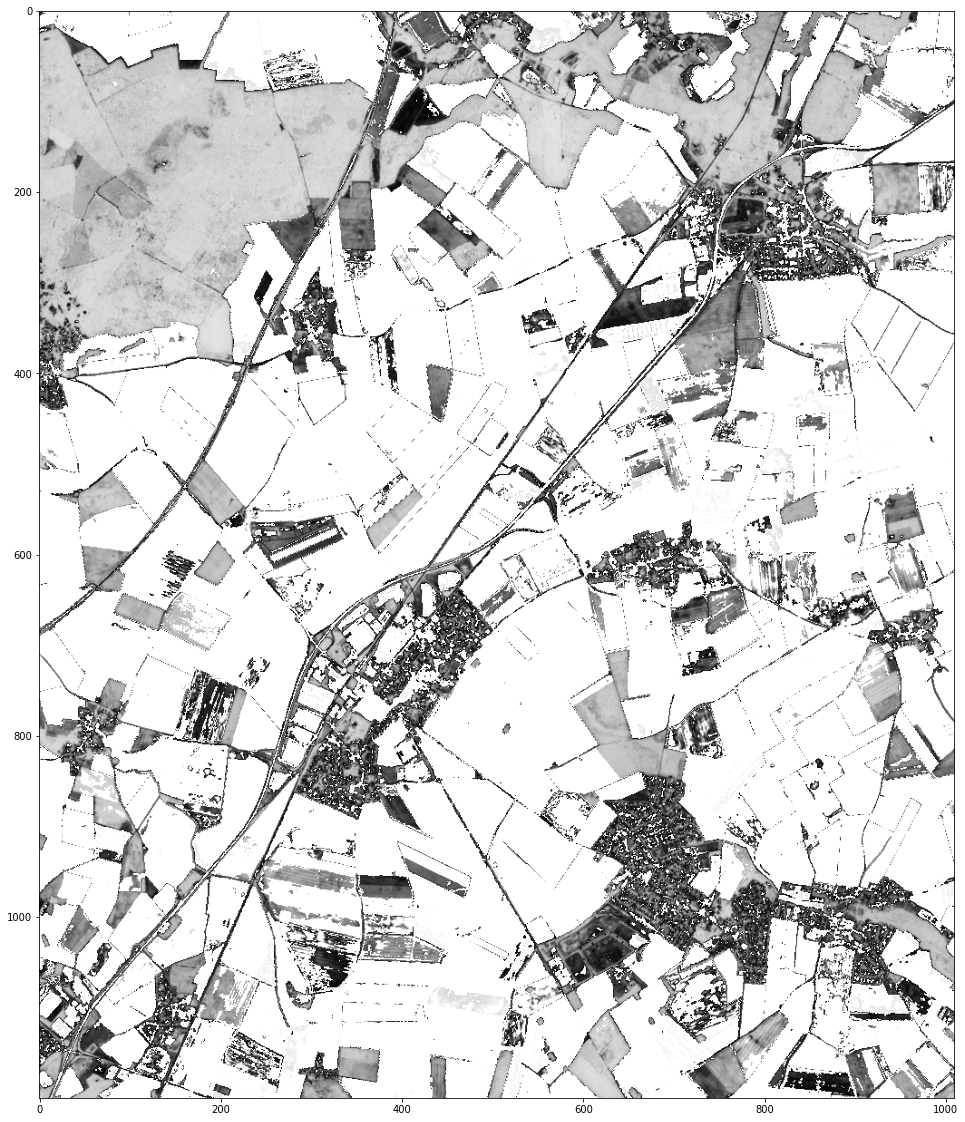

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(ndvi, cmap="gray")

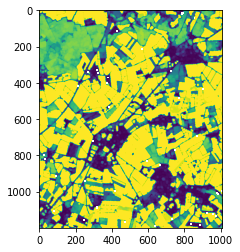

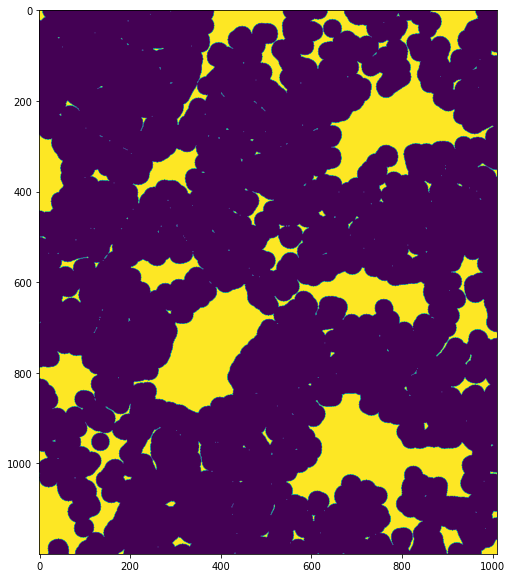

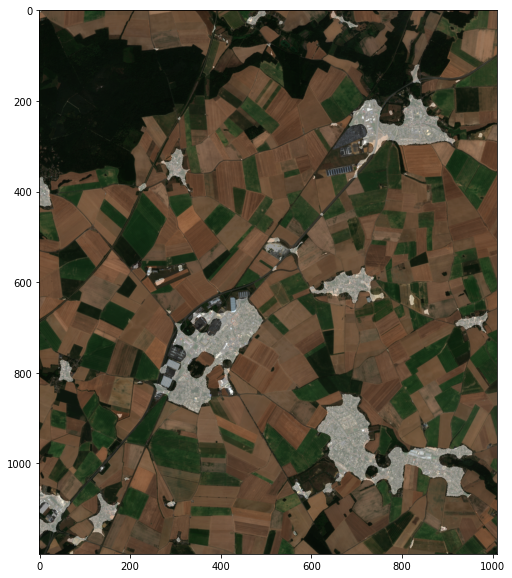

In [ ]:
def mask_cities(rgb, ndvi):
  se = morpho.disk(5)
  img_morph = morpho.opening(ndvi, se)
  plt.imshow(img_morph)
  cities_ndvi = img_morph < 0.05
  cities_ndvi = morpho.binary_opening(cities_ndvi, morpho.disk(3))
  cities_ndvi = morpho.binary_closing(cities_ndvi, morpho.disk(10))


  img = rgb[:,:,0]
  strell = morpho.disk(3)
  cities_top_hat = img - morpho.opening(img, strell)
  cities_top_hat = morpho.closing(cities_top_hat,morpho.disk(20)) > 50

  plt.figure(figsize=(10, 10))
  plt.imshow(cities_top_hat)

  cities = cities_ndvi*cities_top_hat

  return cities

cities = mask_cities(img_rgb, ndvi)


plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.imshow(cities,cmap="gray",alpha=0.4)

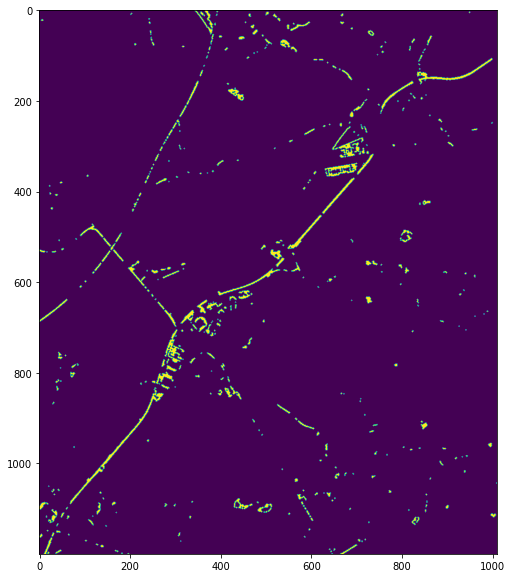

In [ ]:
def mask_roads(ndvi, ir):
  img_bg = ir
  fields = (ndvi>0.90)*(img_b8<100)
  fields = scipy.ndimage.convolve(fields,np.array([[1,1,1],[0,0,0],[-1,-1,-1]]))
  fields = morpho.binary_closing(fields, morpho.diamond(1))

  se = morpho.disk(5)
  img_morph = morpho.opening(ndvi, se)
  cities_ndvi = img_morph < 0.05
  cities_ndvi = morpho.binary_opening(cities_ndvi, morpho.disk(3))
  cities_ndvi = morpho.binary_closing(cities_ndvi, morpho.disk(10))

  img = img_b4
  strell = morpho.disk(3)
  cities_top_hat = img - morpho.opening(img, strell)
  cities_top_hat = morpho.closing(cities_top_hat,morpho.disk(20)) > 50

  img_r = fields*np.invert(cities_ndvi*cities_top_hat)
  ### start code
  strell = morpho.disk(5)

  top_hat_r = morpho.white_tophat(img_r, strell)

  strell = morpho.disk(1)
  streets = morpho.opening(top_hat_r, strell)
  return streets

plt.figure(figsize=(10, 10))
plt.imshow(mask_roads(ndvi, img_b8))

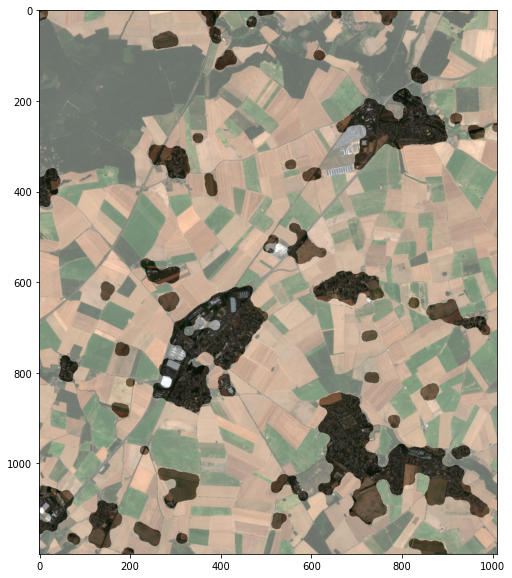

In [ ]:
fields = ndvi>0.05
#fields = morpho.binary_opening(fields, morpho.disk(5))
fields = morpho.binary_opening(fields, morpho.disk(10))
fields = morpho.binary_closing(fields, morpho.disk(10))


plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.imshow(fields,cmap="gray",alpha=0.4)

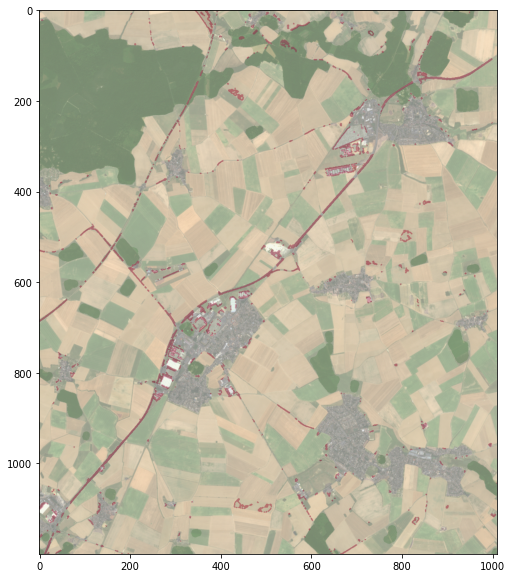

In [ ]:
# get forests
forests = img_b2 < 30
str_elem = morpho.disk(2)
forests = morpho.opening(forests, str_elem)
forests = morpho.closing(forests, morpho.disk(10))
forests = morpho.opening(forests, morpho.disk(8))

# streets
roads = mask_roads(ndvi, img_b8)

# plot
segmentation = np.ones(img_rgb.shape)

segmentation[:] = np.array([241,243,223])/255
segmentation[cities == 1] = np.array([217,217,217])/255
segmentation[forests == 1] =  np.array([195,218,181])/255
#segmentation[roads == 1] = np.array([213,116,136])/255


plt.figure(figsize=(10, 10))
plt.imshow(segmentation)
plt.imshow(img_rgb,alpha=0.4)



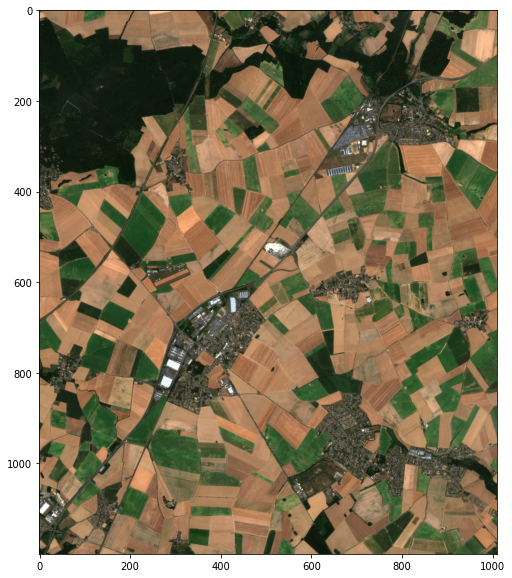

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)

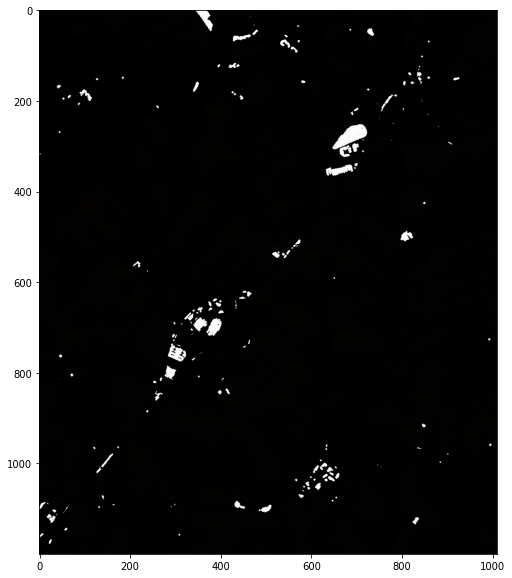

In [ ]:
forests = img_b8 < 100

str_elem = morpho.disk(2)
forests = morpho.opening(forests, str_elem)
#forests = morpho.closing(forests, morpho.disk(10))
#forests = morpho.opening(forests, morpho.disk(8))

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.imshow(forests*np.invert(cities),cmap="gray",alpha=0.99)

In [ ]:
fields = (ndvi>0.05)*(img_b8<100)
fields = scipy.ndimage.convolve(fields,np.array([[1,1,1],[0,0,0],[-1,-1,-1]]))
fields = morpho.binary_closing(fields, morpho.diamond(3))
roads = fields*np.invert(cities)

plt.figure(figsize=(10, 10))
#plt.imshow(img_rgb)
plt.imshow(fields*np.invert(cities),cmap="gray",alpha=1)

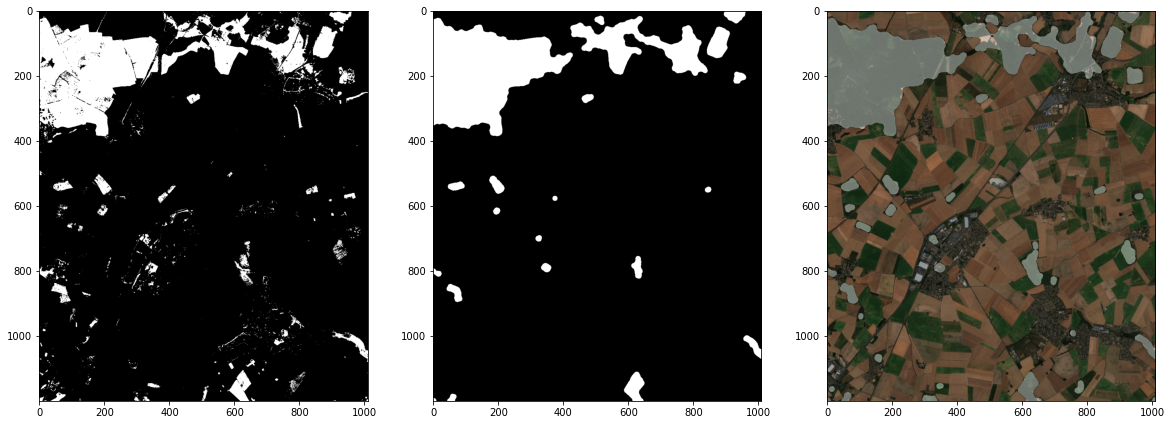

In [ ]:
get_big_forests = img_b2 < 25

str_elem = morpho.disk(2)
img_open = morpho.opening(get_big_forests, str_elem)
img_open = morpho.closing(img_open, morpho.disk(10))
img_open = morpho.opening(img_open, morpho.disk(8))

fig, ax = plt.subplots(1, 3,  figsize = (20, 20))
ax[0].imshow(get_big_forests, cmap = 'gray')
ax[1].imshow(img_open, cmap = 'gray')
ax[2].imshow(np.dstack([img_b4,img_b3,img_b2]))
ax[2].imshow(forests*np.invert(cities), cmap = 'gray', alpha = 0.4)